# Assignment 2: Improving the Machine Learning Pipeline

Ari Anisfeld

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import math

import pipeline.magicloops as magic
import pipeline.util as u
import pipeline.process as pr
import pipeline.read as r
import pipeline.explore as ex
import pipeline.evaluate as ev
% matplotlib inline


data = r.read_csv('data/credit-data.csv', parse_zipcodes=["zipcode"], dtype ={"SeriousDlqin2yrs": "category","PersonID":"category"})
data.serious_dlqin2yrs.cat.categories = ["Nondelinquent", "Delinquent"]

data = r.read_csv('data/credit-data.csv', parse_zipcodes=["zipcode"], dtype ={"PersonID":"category"})
#data.serious_dlqin2yrs.cat.categories = ["Nondelinquent", "Delinquent"]
data["debt_ratio_groups"] = pr.cut(data.debt_ratio, [0,0.25,.5,.75,1], labels="auto")

# This apply function is too slow.
# data.debt_ratio = data.debt_ratio.apply(lambda x: pr.cap_values(x,data.debt_ratio.quantile(.99)))

#Fill Na with mean for monthly income and median for number of dependents
na_cols = ["monthly_income","number_of_dependents"]
data[na_cols] = pr.fill_with(df=data,col=na_cols, group="serious_dlqin2yrs")


#binnerize number of dependents data and then make dummies.
data["number_of_dependents_cut"] = pr.cut(data.number_of_dependents, [0,.99,3.01,20.1], \
                                          method=pd.cut, labels=["No dependents","1-3 dependents", "4+ dependents"],include_lowest=True)
data = pr.get_dummies(data.number_of_dependents_cut, data)

df = data
potential_features = list(data.columns[2:14])
y = df.serious_dlqin2yrs
X =df[potential_features].join(df.monthly_income.map(lambda x: math.log(x) if x!=0 else 0), rsuffix="_log")




/Users/arianisfeld/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Users/arianisfeld/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/arianisfeld/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the re


# Explore Data

The below table shows outcomes split by data labeled delinquent or nondelinquent. The number of times delinquents are past due is an order of magnitude higher than nondelinquents, but the high variance on the measure and low median suggest that is driven by people with particularly high numbers of past due bills. Nondelinquents are older and have higher income on average.

In [3]:
summary = x.summary_by_outcome(data, "serious_dlqin2yrs")

summary.ix[:,[0,1,2,4,6,7,8,10]]

serious_dlqin2yrs                           Nondelinquent                     \
                                                    count     mean       std   
age                                              139974.0    52.75     14.79   
debt_ratio                                       139974.0   357.15   2083.28   
monthly_income                                   111912.0  6747.84  14813.50   
number_of_dependents                             136229.0     0.74      1.11   
number_of_open_credit_lines_and_loans            139974.0     8.49      5.11   
number_of_time30-59_days_past_due_not_worse      139974.0     0.28      2.95   
number_of_time60-89_days_past_due_not_worse      139974.0     0.13      2.90   
number_of_times90_days_late                      139974.0     0.14      2.91   
number_real_estate_loans_or_lines                139974.0     1.02      1.11   
revolving_utilization_of_unsecured_lines         139974.0     6.17    256.13   

serious_dlqin2yrs                                    Delinquent           \
                                                 50%      count     mean   
age                                            52.00    10026.0    45.93   
debt_ratio                                      0.36    10026.0   295.12   
monthly_income                               5466.00     8357.0  5630.83   
number_of_dependents                            0.00     9847.0     0.95   
number_of_open_credit_lines_and_loans           8.00    10026.0     7.88   
number_of_time30-59_days_past_due_not_worse     0.00    10026.0     2.39   
number_of_time60-89_days_past_due_not_worse     0.00    10026.0     1.83   
number_of_times90_days_late                     0.00    10026.0     2.09   
number_real_estate_loans_or_lines               1.00    10026.0     0.99   
revolving_utilization_of_unsecured_lines        0.13    10026.0     4.37   

serious_dlqin2yrs                                              
                                                 std      50%  
age                                            12.92    45.00  
debt_ratio                                   1238.36     0.43  
monthly_income                               6171.72  4500.00  
number_of_dependents                            1.22     0.00  
number_of_open_credit_lines_and_loans           5.65     7.00  
number_of_time30-59_days_past_due_not_worse    11.73     0.00  
number_of_time60-89_days_past_due_not_worse    11.75     0.00  
number_of_times90_days_late                    11.76     0.00  
number_real_estate_loans_or_lines               1.43     1.00  
revolving_utilization_of_unsecured_lines      131.84     0.84

In [4]:
null_income = u.check_nulls(data, "monthly_income")
null_sum = x.summary_by_outcome(null_income, "serious_dlqin2yrs")

not_null_income = u.get_notnulls(data, "monthly_income")
not_null_sum = x.summary_by_outcome(not_null_income, "serious_dlqin2yrs")
ratio = round(null_sum.ix[:,[0,1,2,5,6,7,8,11]]/not_null_sum.ix[:,[0,1,2,5,6,7,8,11]],2)
ratio.drop("monthly_income")

serious_dlqin2yrs                           Nondelinquent                      \
                                                    count   mean    std   max   
age                                                  0.25   1.10   1.06  1.06   
debt_ratio                                           0.25  62.04  10.12  5.39   
number_of_dependents                                 0.22   0.37   0.70  0.45   
number_of_open_credit_lines_and_loans                0.25   0.83   0.94  0.78   
number_of_time30-59_days_past_due_not_worse          0.25   1.31   1.85  1.00   
number_of_time60-89_days_past_due_not_worse          0.25   2.40   1.89  1.00   
number_of_times90_days_late                          0.25   2.27   1.88  1.00   
number_real_estate_loans_or_lines                    0.25   0.83   0.92  0.43   
revolving_utilization_of_unsecured_lines             0.25   1.08   0.82  0.44   

serious_dlqin2yrs                           Delinquent                     
                                                 count   mean   std   max  
age                                               0.20   1.01  1.09  0.98  
debt_ratio                                        0.20  77.49  6.67  1.86  
number_of_dependents                              0.18   0.37  0.75  0.75  
number_of_open_credit_lines_and_loans             0.20   0.74  0.94  0.60  
number_of_time30-59_days_past_due_not_worse       0.20   2.32  1.90  1.00  
number_of_time60-89_days_past_due_not_worse       0.20   3.00  1.91  1.00  
number_of_times90_days_late                       0.20   2.74  1.90  1.00  
number_real_estate_loans_or_lines                 0.20   0.69  0.78  0.52  
revolving_utilization_of_unsecured_lines          0.20   2.17  2.12  1.35

The analysis above compares people who have a reported monthly income and those with null monthly incomes. The ratio of missing income data over debt ratio with income data is very large. Those without income data have 62 to 77 times the debt ratio of those with reported data. In general, we would hope these ratios were close to 1. The count data show for each person with missing data there are 4 to 5 people with reported income. In other words, those with missing data make up slightly under 20 percent of our data. I will have to be careful when developing models to account for this discrepancy. For example, in a large project I would compare models with imputed values for the missing income data with dropping the data and would consider capping debt ratios. The graphs below show that the data with nulls has more extreme debt ratios (compare the bottom corners of the following two pair plots). The solution is I will implement will be to group debt ratios.

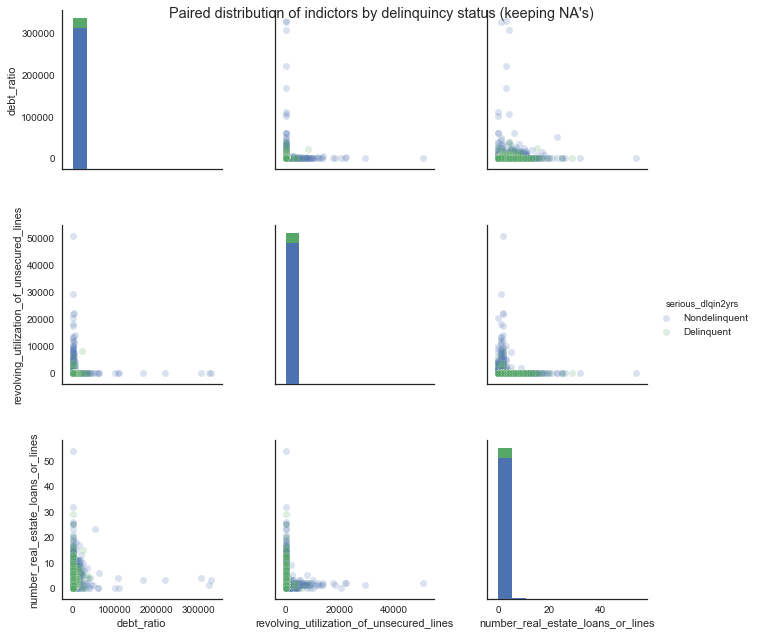

In [7]:
sns.set(style="white")
sns.pairplot(data, vars=["debt_ratio","revolving_utilization_of_unsecured_lines","number_real_estate_loans_or_lines"],\
             hue="serious_dlqin2yrs", size=3, plot_kws={'alpha':0.2})
pl.suptitle("Paired distribution of indictors by delinquincy status (keeping NA's)")

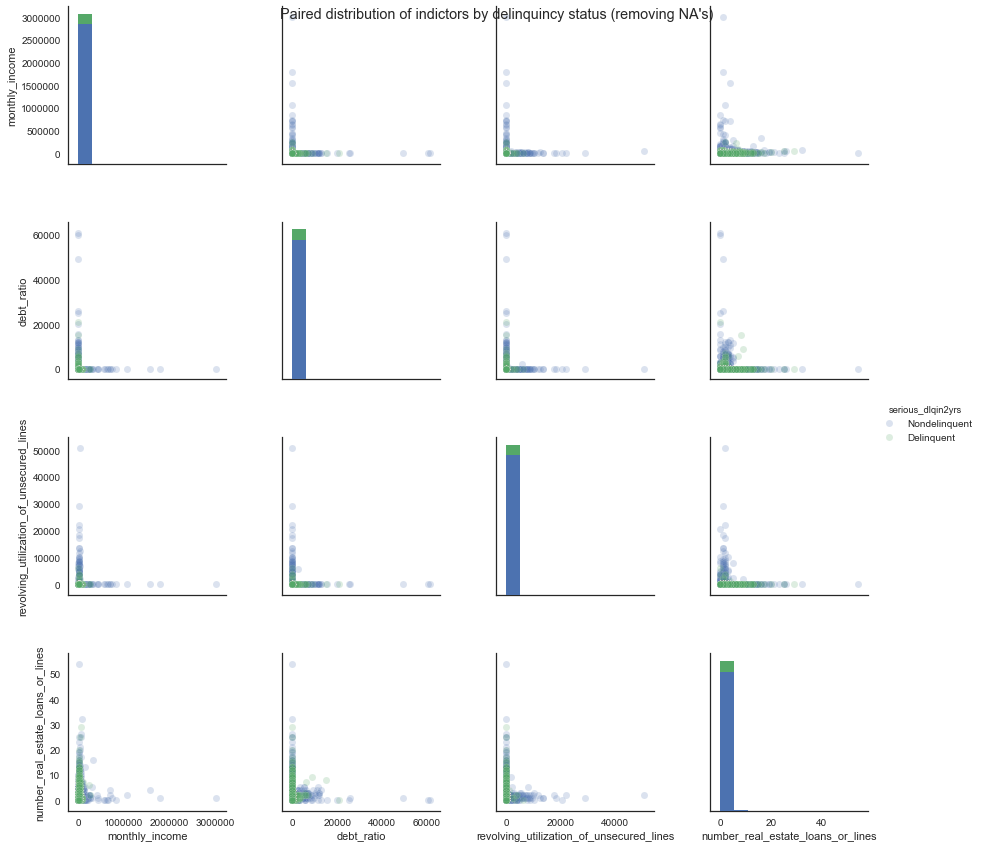

In [8]:
sns.pairplot(u.get_notnulls(data,"monthly_income"), vars=["monthly_income","debt_ratio","revolving_utilization_of_unsecured_lines","number_real_estate_loans_or_lines"],\
             hue="serious_dlqin2yrs", size=3, plot_kws={'alpha':0.2})
pl.suptitle("Paired distribution of indictors by delinquincy status (removing NA's)")

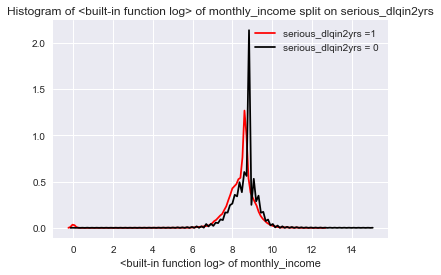

In [109]:
import math

"""normalized_data = data.monthly_income.map(lambda x: math.log(x) if x != 0 else 0)

sns.distplot(normalized_data.loc[data.serious_dlqin2yrs==1], color = 'red', hist=False)
sns.distplot(normalized_data.loc[data.serious_dlqin2yrs==0], color = 'black', hist=False)
plt.xlim = (5, 11)
plt.show()
"""

def no_correction_function(x):
    return x

def my_distplot(df, col, binary_split=None,fn=no_correction_function, hist=False, kde=True):
    '''
    df (dataFrame)
    col (column in dataFrame) we expect values >= 0 
    binary_split (column in df of 0 and 1)
    fn (function) (e.g. math.log, math.sqrt)
    FUTURE: use quantile or other methods to cut outliers
    FUTURE: make arbitrary distinct graphs not just binary
    '''
    normalized_data = df[col].map(lambda x: fn(x) if x > 0 else x)
    if binary_split:
        sns.distplot(normalized_data.loc[df[binary_split]==1], color = 'red', hist=hist,kde=kde, label='{} =1'.format(binary_split))
        sns.distplot(normalized_data.loc[df[binary_split]==0], color = 'black',hist=hist,kde=kde,label='{} = 0'.format(binary_split))
        plt.title("Histogram of {} of {} split on {}".format(fn, col, binary_split))
    else:
        sns.distplot(normalized_data)
        plt.title("Histogram of {} of {}".format(fn, col), label = col)
    if fn==no_correction_function:
        plt.xlabel("{}".format(col))
    else:
        plt.xlabel("{} of {}".format(fn, col))
    plt.legend()
    

    
my_distplot(data, 'monthly_income', 'serious_dlqin2yrs',fn=math.log)


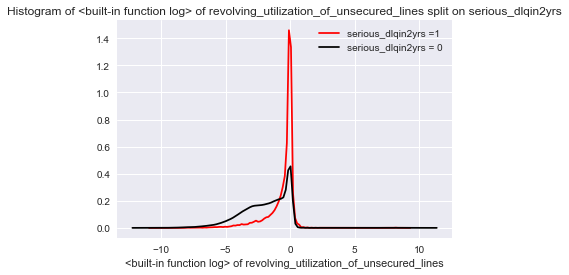

In [106]:
my_distplot(data, 'revolving_utilization_of_unsecured_lines', 'serious_dlqin2yrs',fn=math.log)

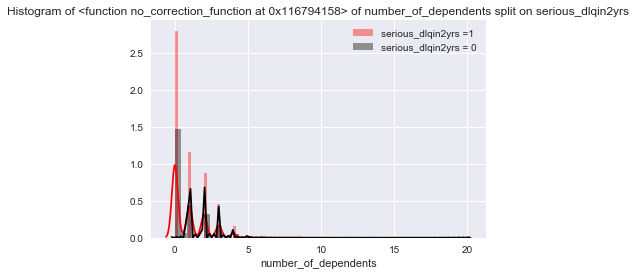

In [111]:
my_distplot(data, 'number_of_dependents', 'serious_dlqin2yrs', hist=True, kde=True)

In [90]:
normalized_data = data.monthly_income.map(lambda x: math.log(x) if x != 0 else 0)

data.loc[data.serious_dlqin2yrs==1]['number_of_dependents'].value_counts()
#sns.distplot(normalized_data.loc[data.serious_dlqin2yrs==0], color = 'black', hist=False)

0.000000    5095
1.000000    1935
2.000000    1584
3.000000     837
4.000000     297
0.948208     179
5.000000      68
6.000000      24
7.000000       5
8.000000       2
Name: number_of_dependents, dtype: int64

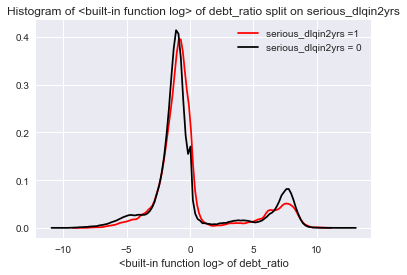

In [81]:
plot_skewed_data(data, 'debt_ratio', 'serious_dlqin2yrs')


# Correlation Plot

The correlation plot shows very strong correlation between the different past-due categories. While age and number of open credit lines and loans are weakly negatively correlated with the past-due categories and uncorrelated with debt ratios, income and number of dependents. Debt ratios, income and number of dependents are postively correlated with number of open credit lines and real estate loans.

I expanded the plot for the second round to include delinquency. Nothing is strongly correlaed with delinquency, though age has the strongest negative correlation.

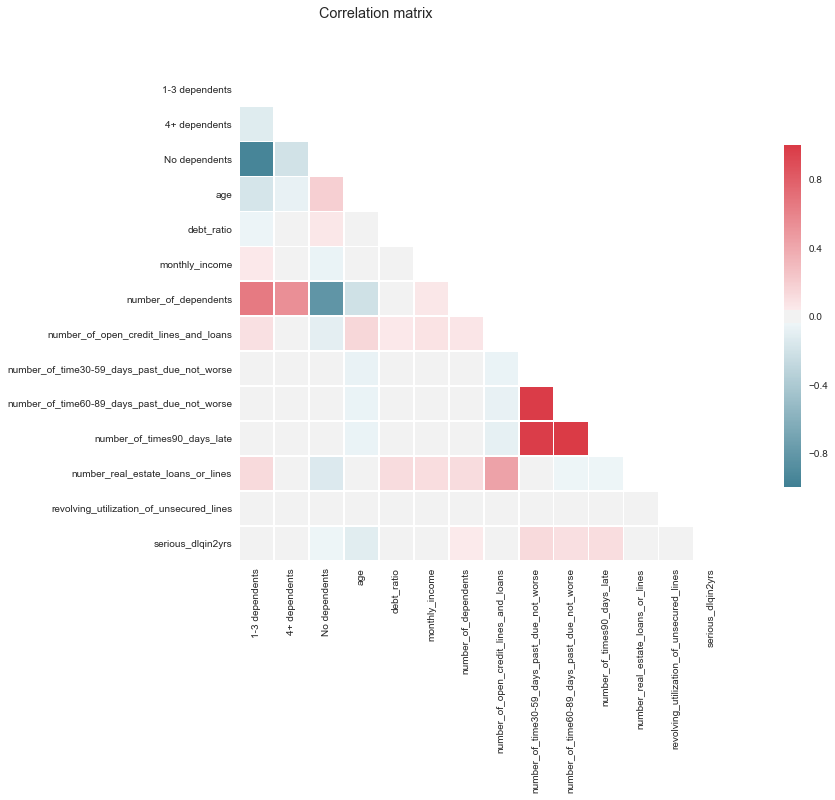

In [182]:
ex.correlation_plot(data)
pl.suptitle("Correlation matrix")

In [10]:
print("Table: Average feature values by zip code")
x.summary_by_outcome(data, "zipcode").iloc[:,1::6]

Table: Average feature values by zip code


zipcode                                        60601    60618    60625  \
                                                mean     mean     mean   
age                                            52.28    52.27    52.33   
debt_ratio                                    341.85   342.50   360.24   
monthly_income                               6686.20  6686.42  6616.10   
number_of_dependents                            0.76     0.75     0.76   
number_of_open_credit_lines_and_loans           8.56     8.44     8.45   
number_of_time30-59_days_past_due_not_worse     0.39     0.42     0.41   
number_of_time60-89_days_past_due_not_worse     0.20     0.24     0.23   
number_of_times90_days_late                     0.22     0.27     0.26   
number_real_estate_loans_or_lines               1.02     1.02     1.03   
revolving_utilization_of_unsecured_lines       10.22     4.24     5.15   

zipcode                                        60629    60637    60644  \
                                                mean     mean     mean   
age                                            52.18    52.25    52.22   
debt_ratio                                    345.67   338.03   373.64   
monthly_income                               6628.62  6805.49  6595.88   
number_of_dependents                            0.76     0.76     0.77   
number_of_open_credit_lines_and_loans           8.39     8.43     8.46   
number_of_time30-59_days_past_due_not_worse     0.40     0.46     0.40   
number_of_time60-89_days_past_due_not_worse     0.22     0.27     0.22   
number_of_times90_days_late                     0.24     0.30     0.25   
number_real_estate_loans_or_lines               1.01     1.02     1.01   
revolving_utilization_of_unsecured_lines        5.03     9.67     3.79   

zipcode                                        60657    60804  
                                                mean     mean  
age                                            52.41    52.40  
debt_ratio                                    357.01   357.87  
monthly_income                               6635.17  6764.87  
number_of_dependents                            0.76     0.74  
number_of_open_credit_lines_and_loans           8.47     8.41  
number_of_time30-59_days_past_due_not_worse     0.39     0.51  
number_of_time60-89_days_past_due_not_worse     0.22     0.33  
number_of_times90_days_late                     0.24     0.36  
number_real_estate_loans_or_lines               1.02     1.01  
revolving_utilization_of_unsecured_lines        7.45     3.75

On average, we do not see major difference betweeen zip codes, despite representing very differen Chicago neighborhoods. Revolving utilization of unsecured lines is the exception. The results were similar when looking at median. Most zipcodes hovered around 16600 residents in the sample, while 60625 zipcode had double that. Despite this, in the feature generation section, I hoped to make dummies of these. I ran into memory issues however, even after reducing the size of the stored integers and using sparse matrices.

# Feature Generation

In [11]:
data["debt_ratio_groups"] = pr.cut(data.debt_ratio, [0,0.25,.5,.75,1], labels="auto")

# This apply function is too slow.
# data.debt_ratio = data.debt_ratio.apply(lambda x: pr.cap_values(x,data.debt_ratio.quantile(.99)))

#Fill Na with mean for monthly income and median for number of dependents
na_cols = ["monthly_income","number_of_dependents"]
data[na_cols] = pr.fill_with(df=data,col=na_cols, group="serious_dlqin2yrs")


#binnerize number of dependents data and then make dummies.
data["number_of_dependents_cut"] = pr.cut(data.number_of_dependents, [0,.99,3.01,20.1], \
                                          method=pd.cut, labels=["No dependents","1-3 dependents", "4+ dependents"],include_lowest=True)
data = pr.get_dummies(data.number_of_dependents_cut, data)

RF


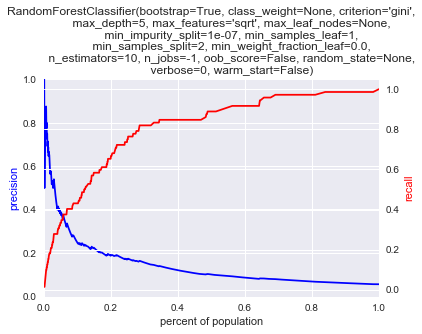

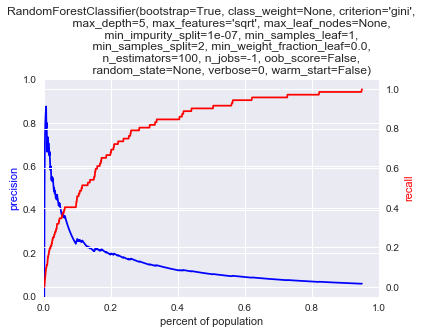

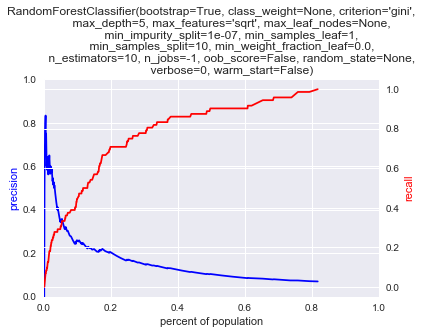

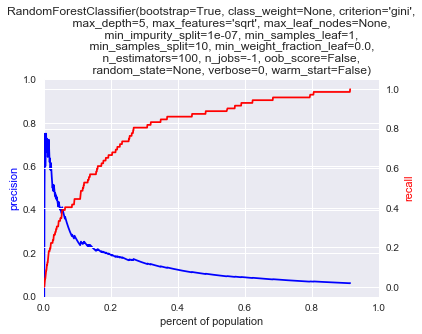

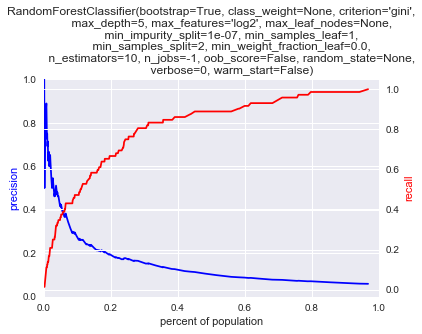

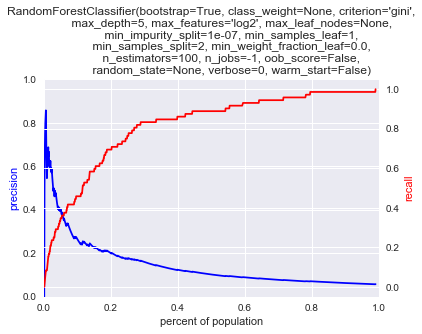

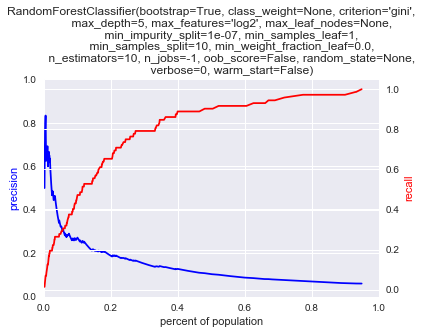

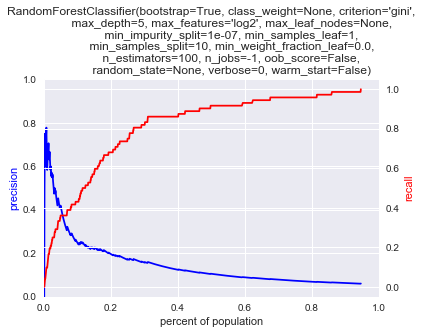

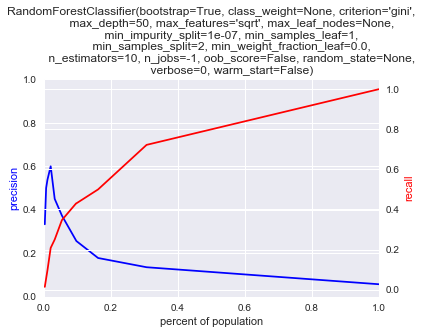

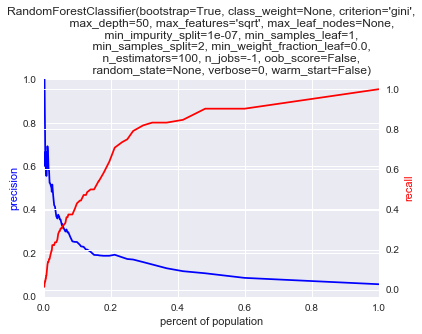

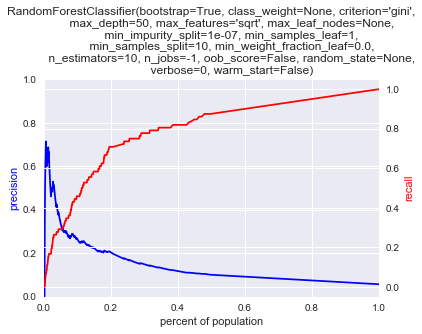

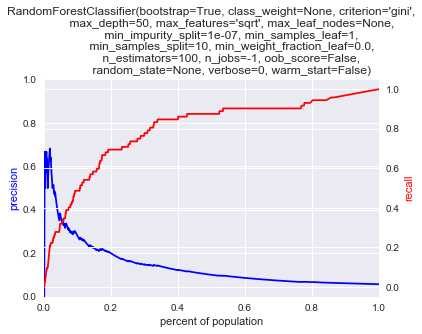

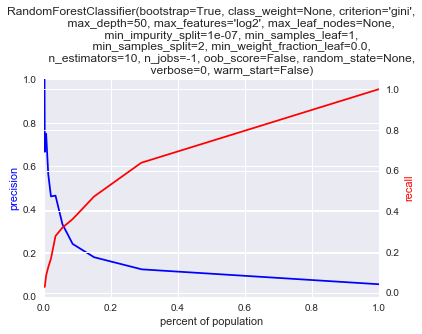

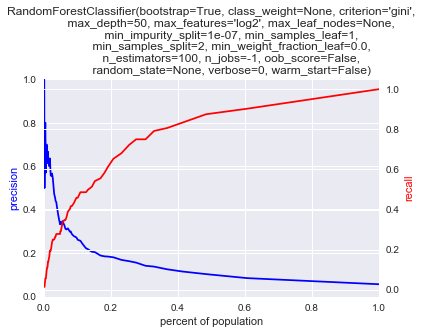

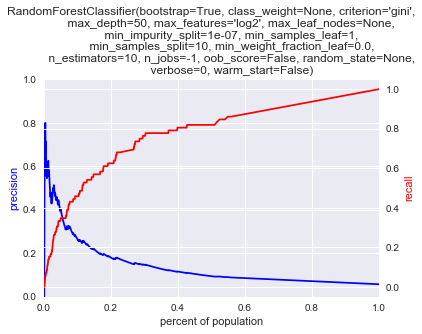

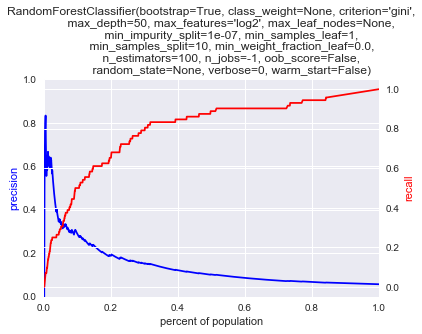

DT


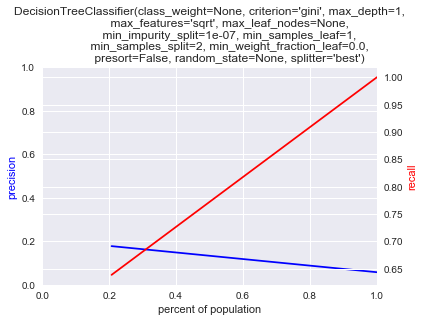

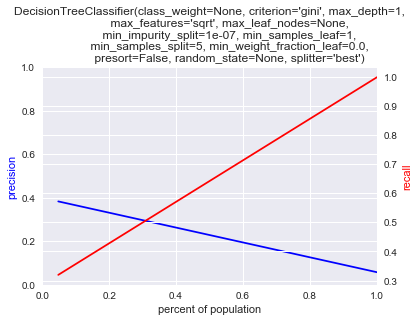

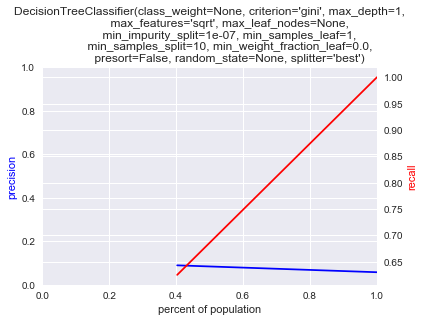

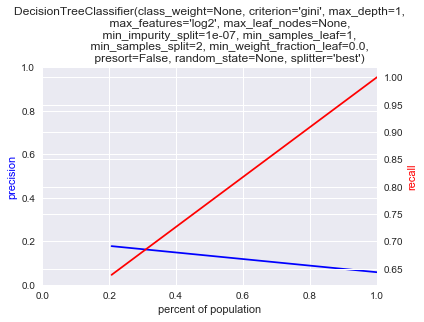

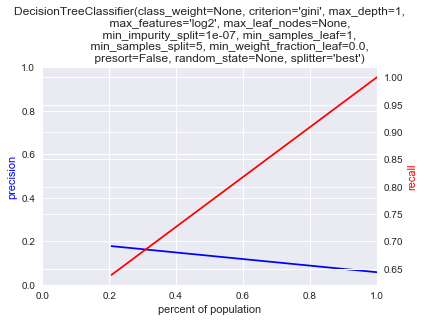

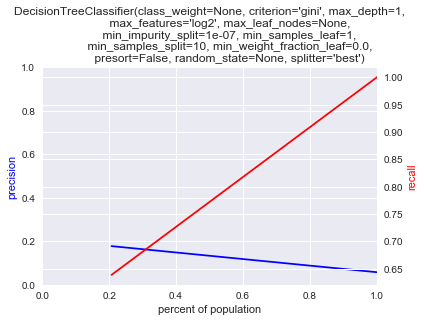

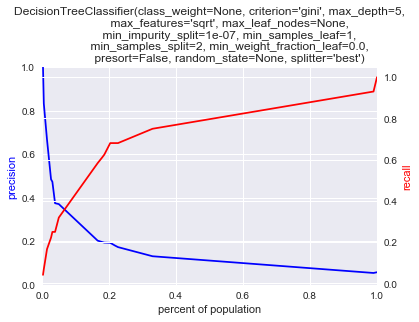

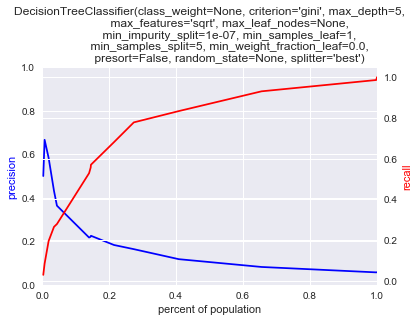

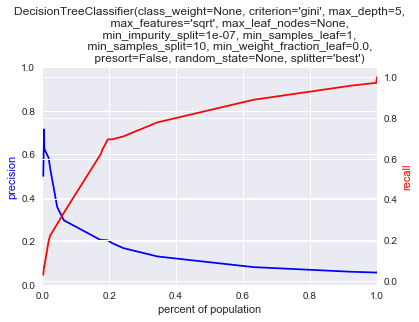

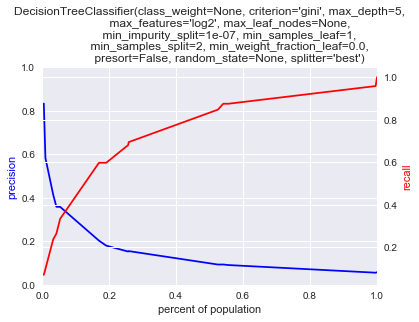

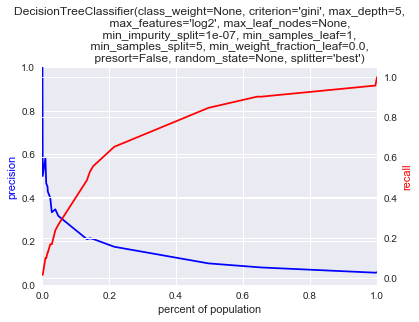

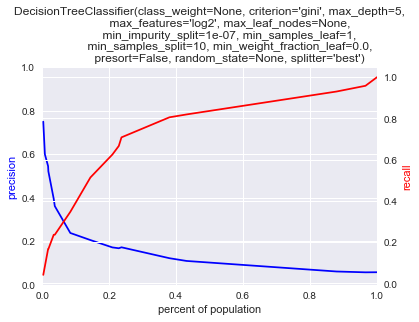

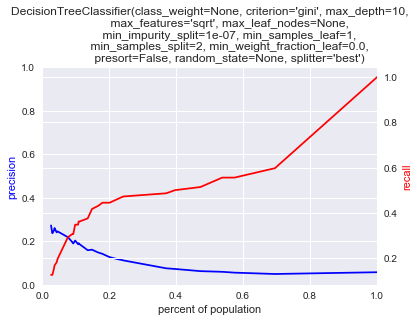

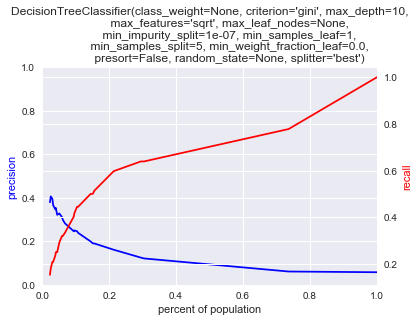

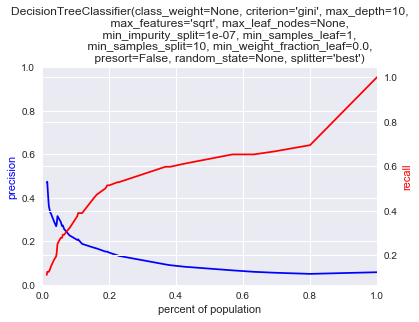

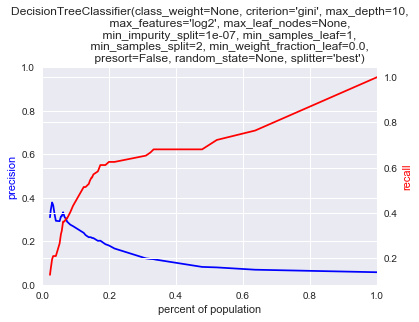

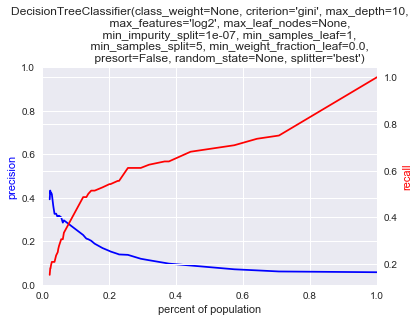

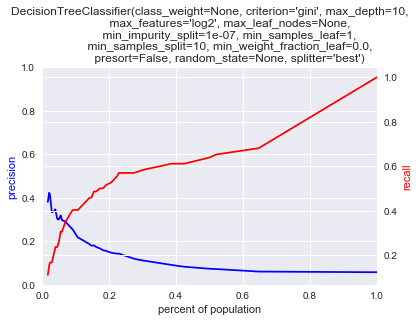

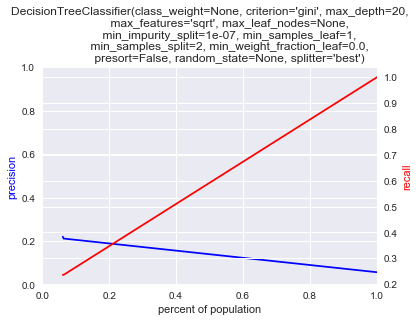

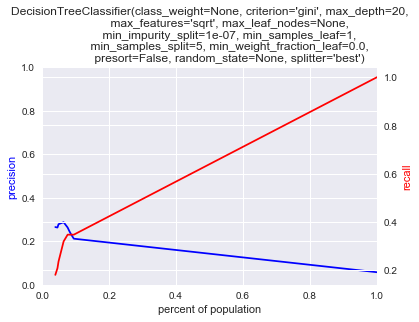

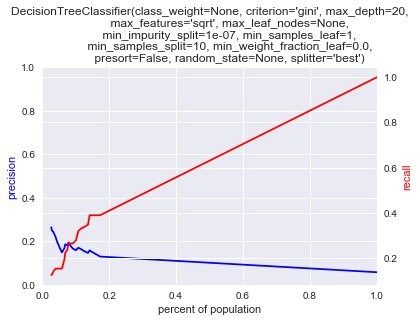

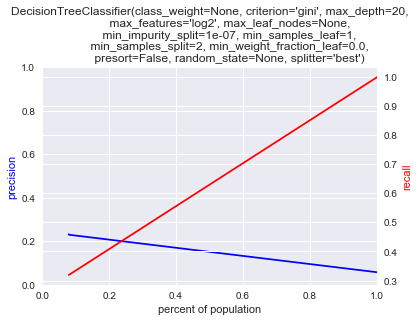

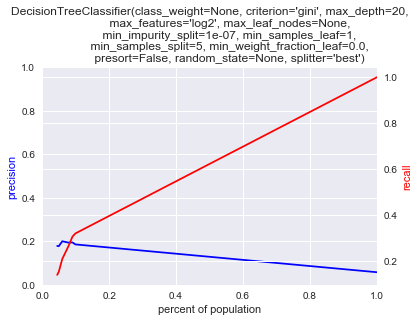

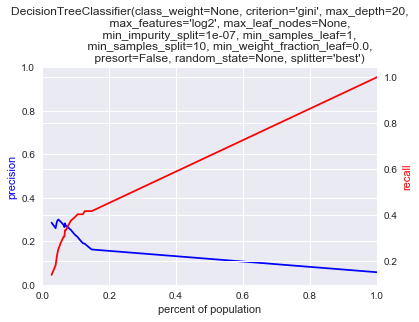

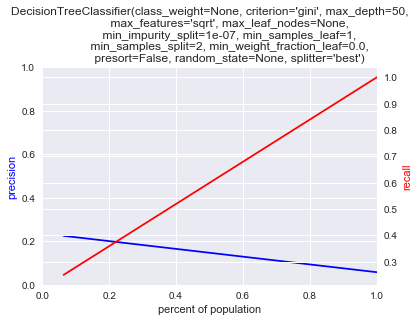

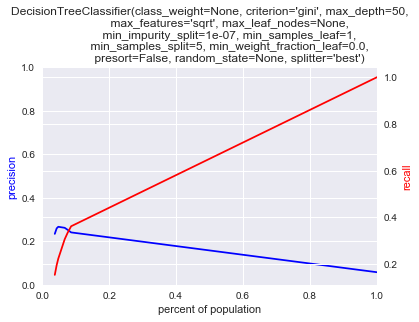

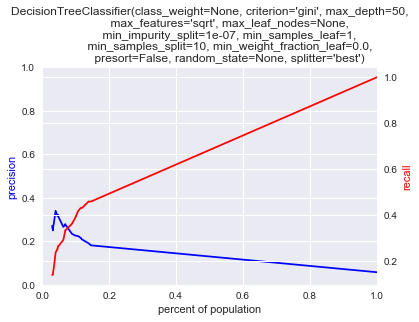

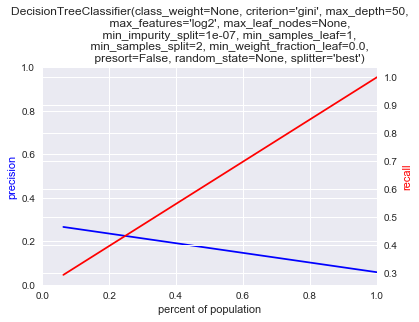

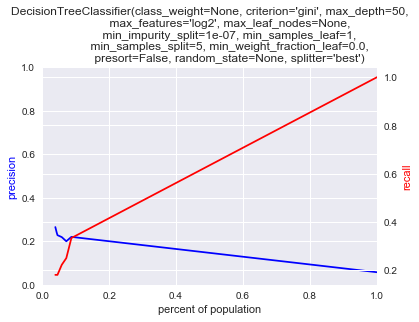

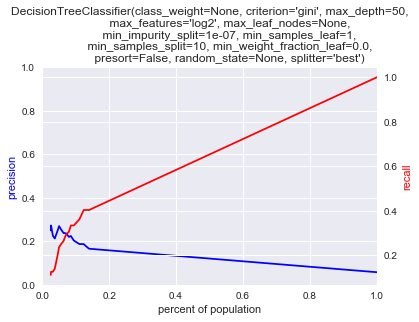

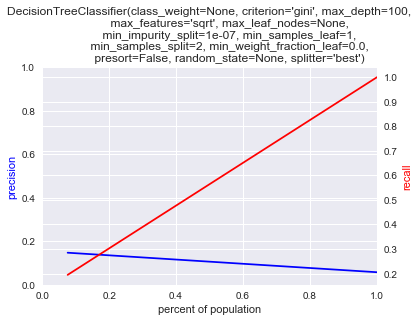

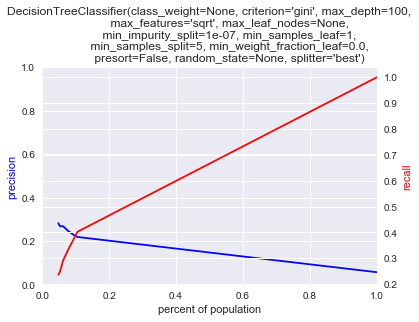

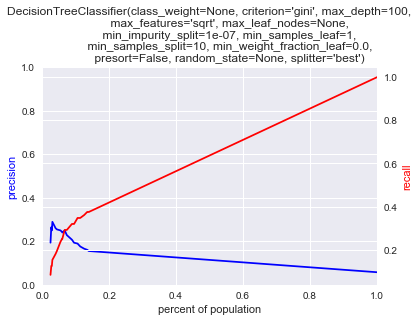

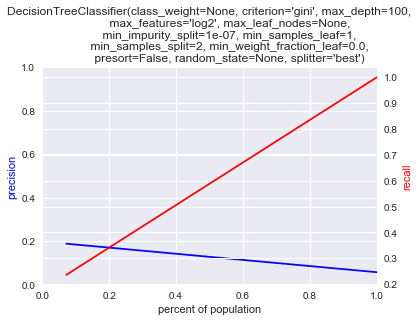

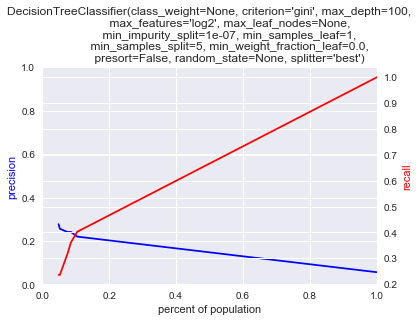

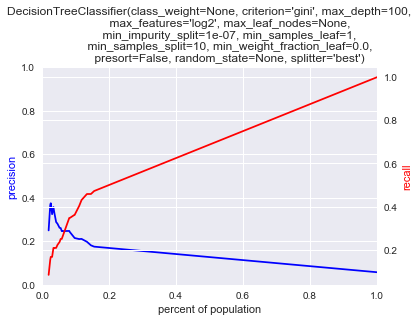

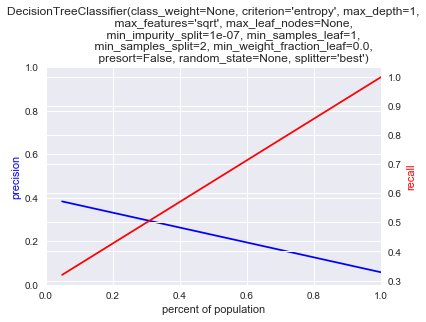

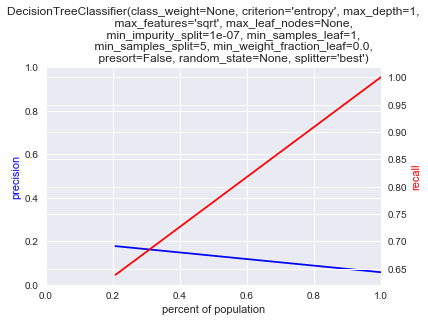

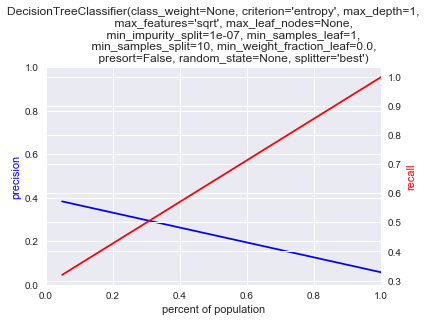

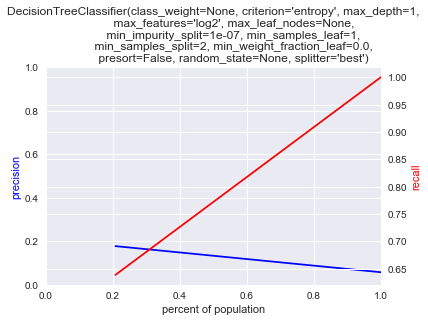

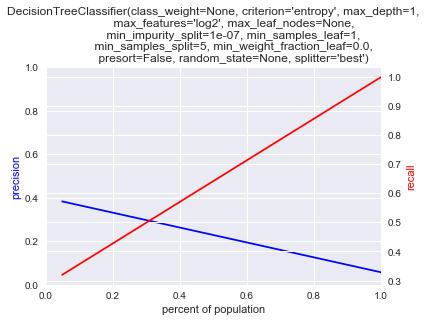

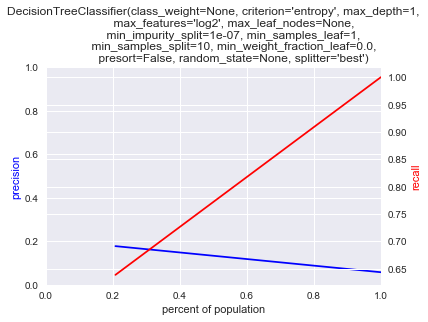

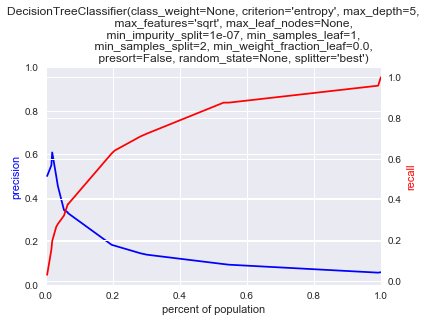

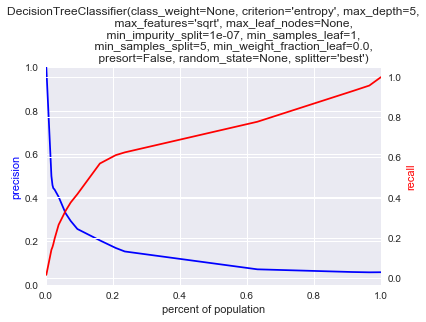

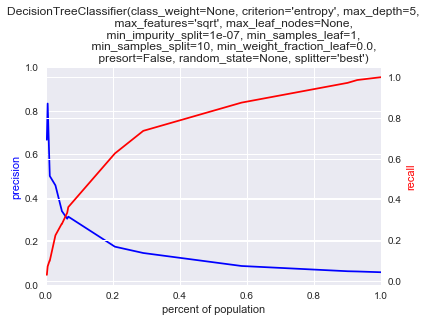

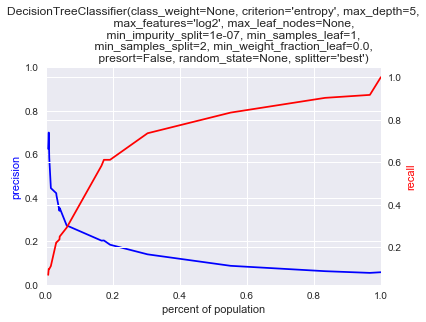

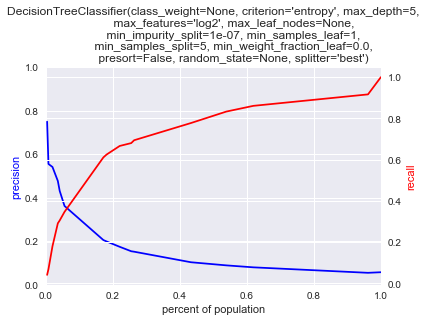

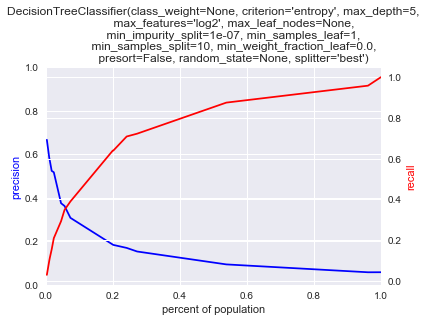

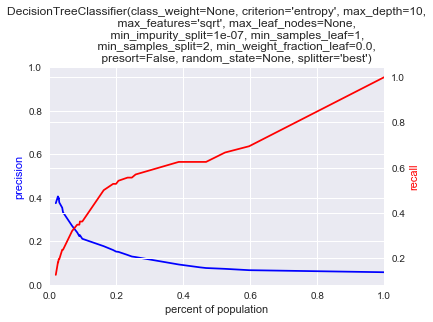

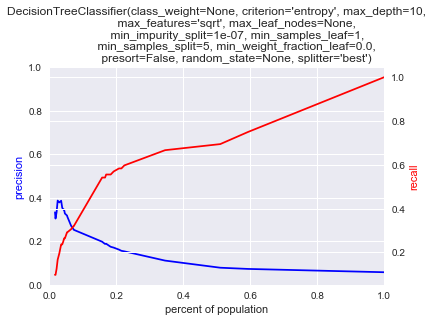

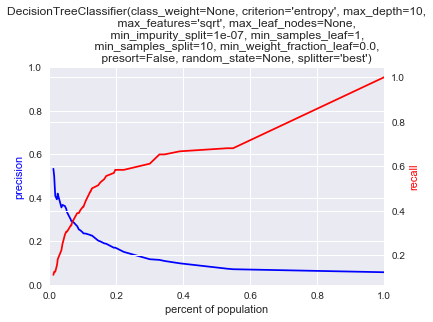

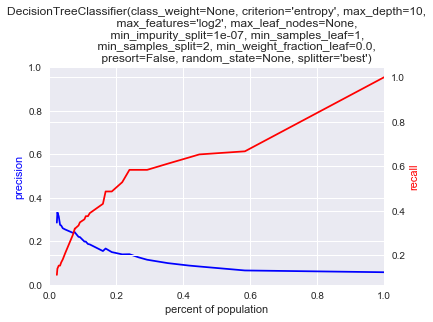

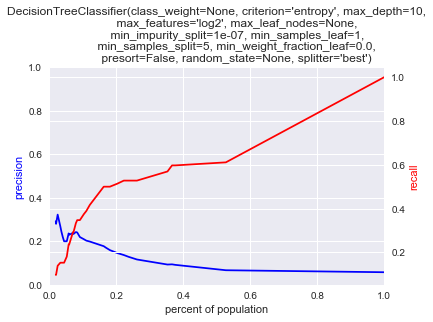

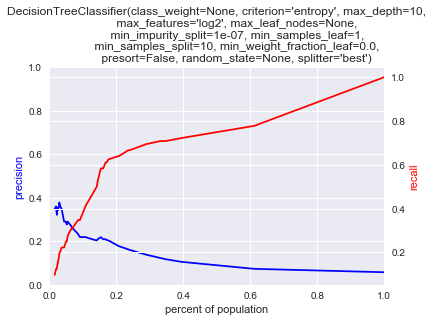

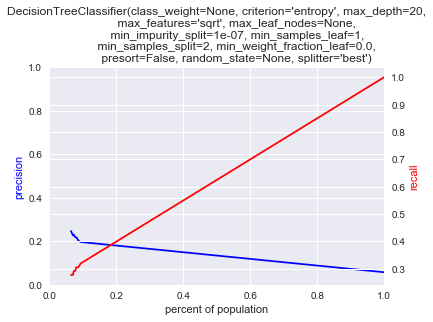

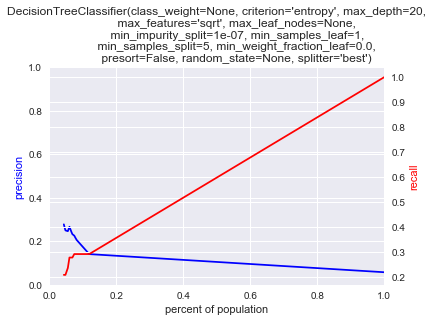

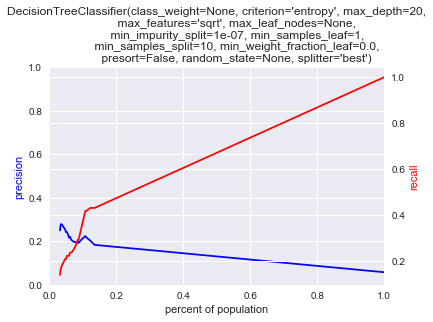

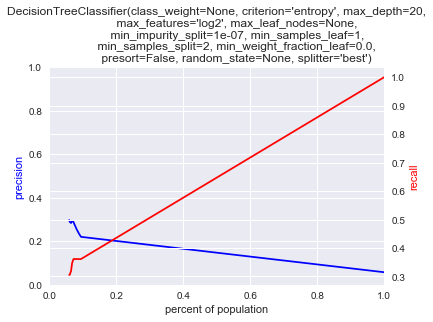

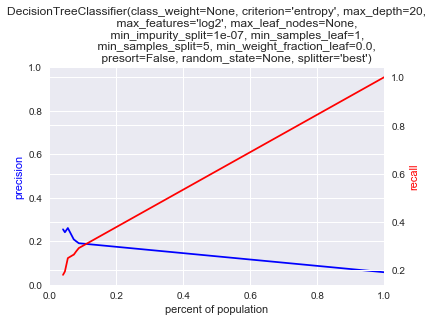

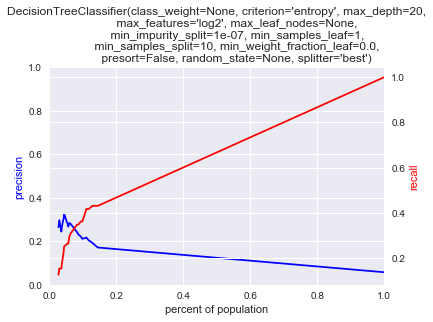

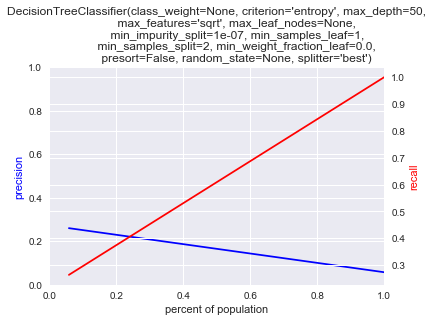

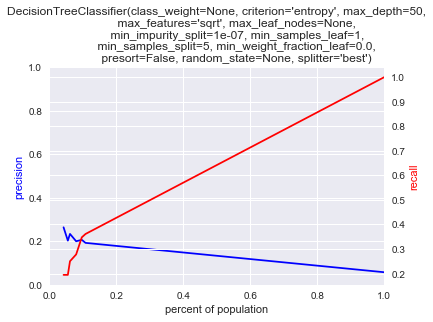

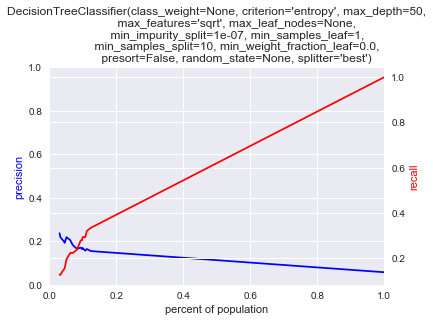

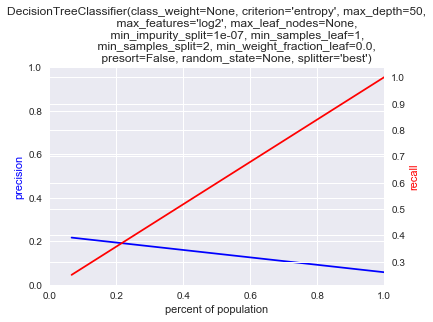

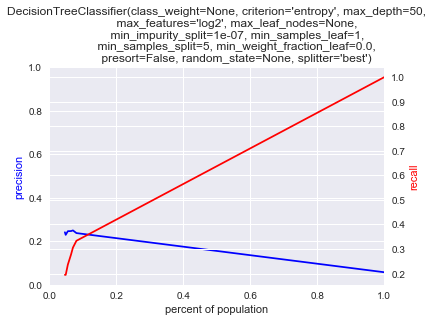

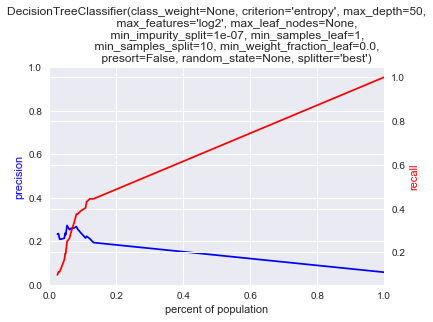

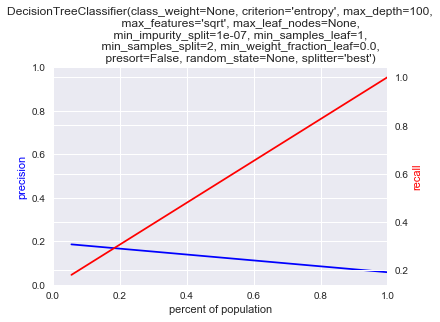

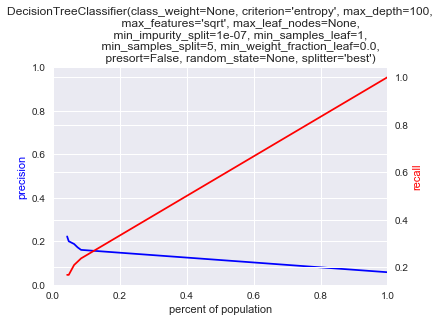

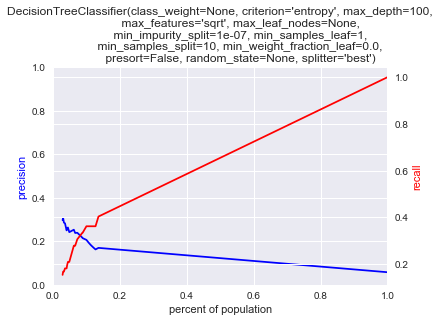

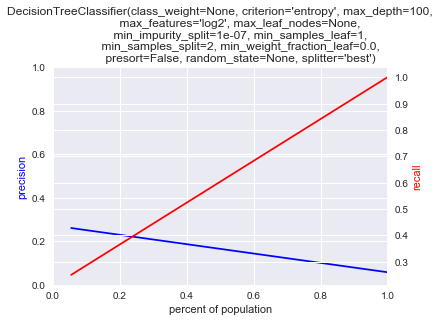

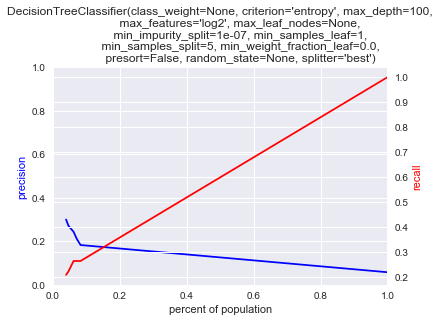

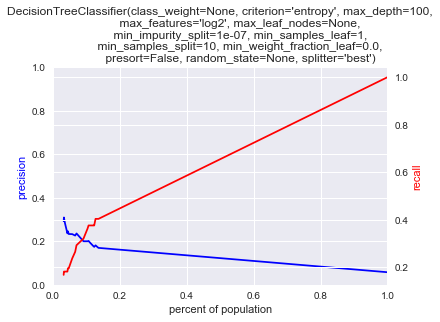

KNN


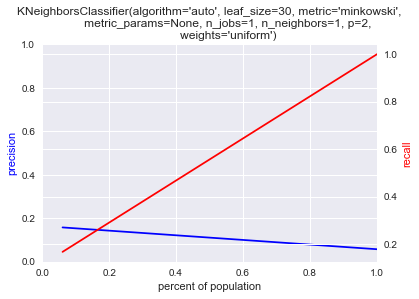

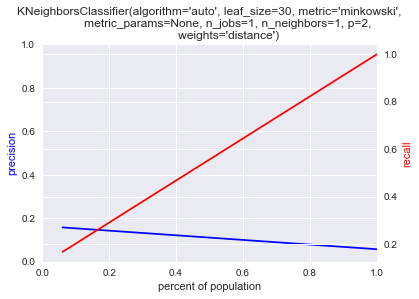

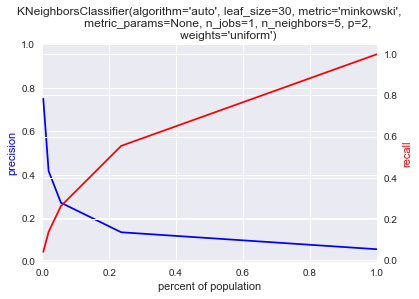

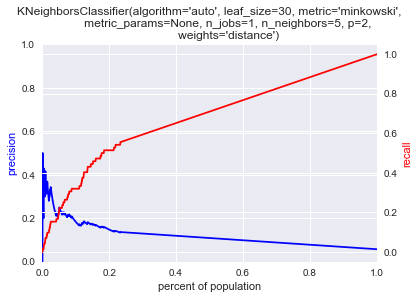

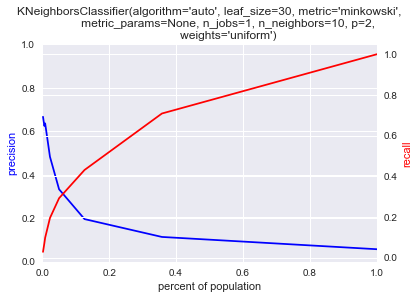

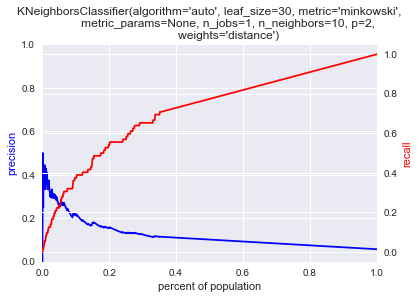

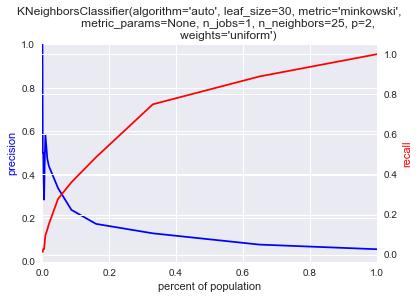

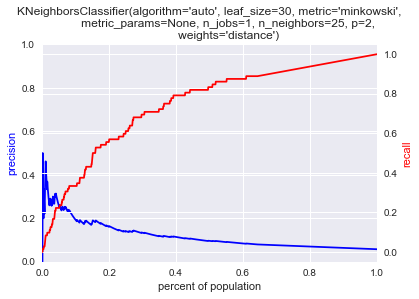

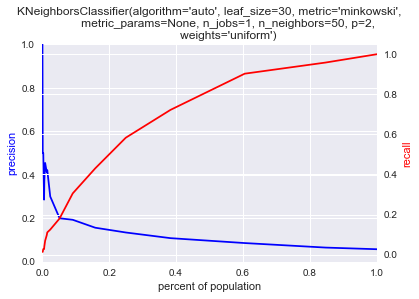

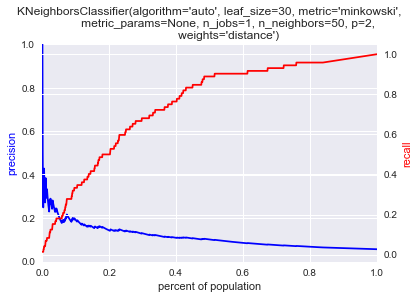

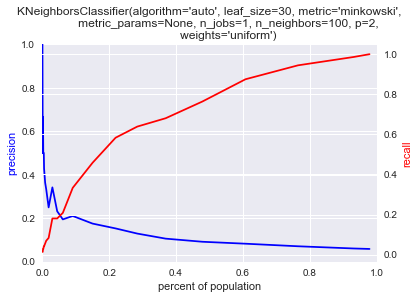

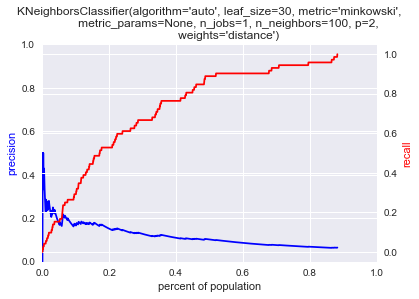

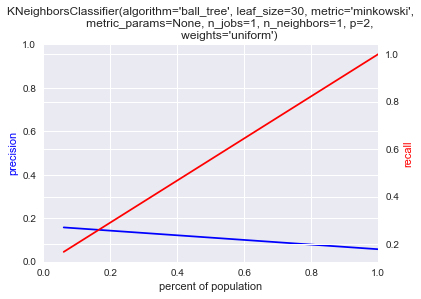

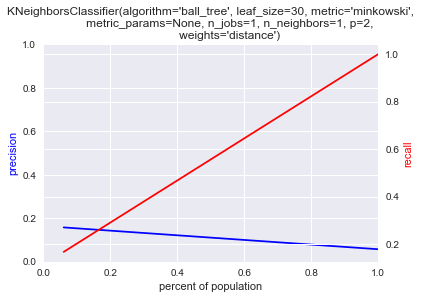

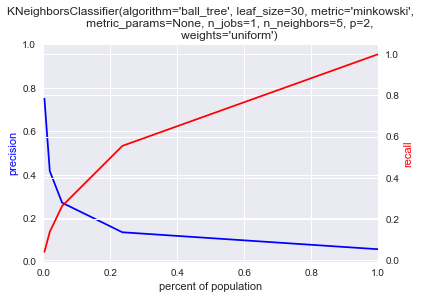

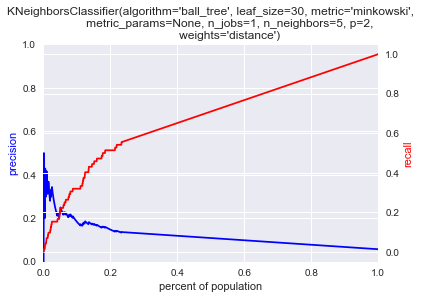

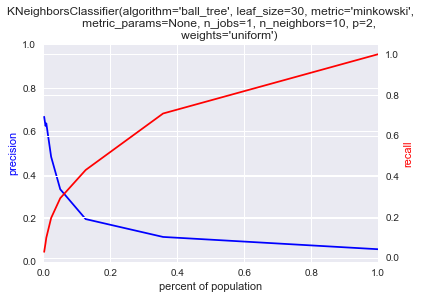

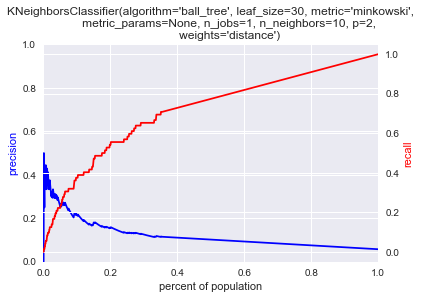

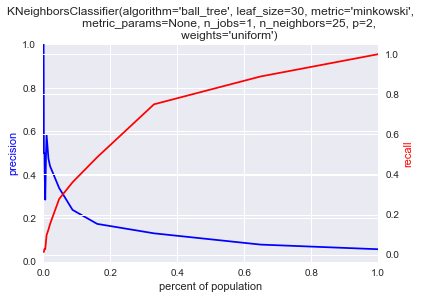

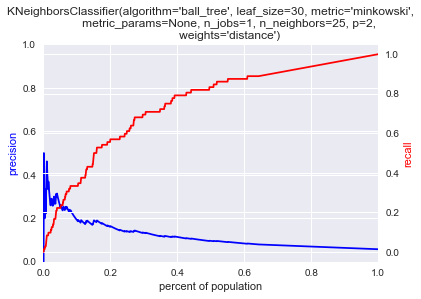

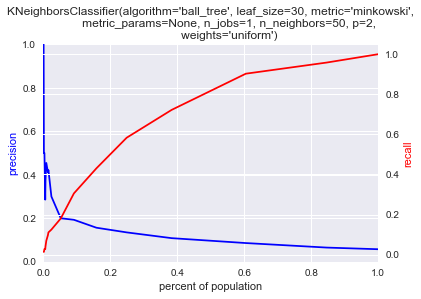

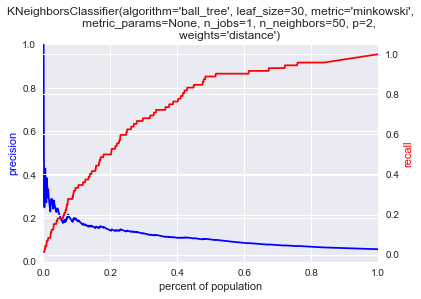

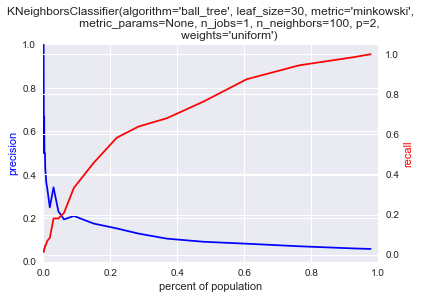

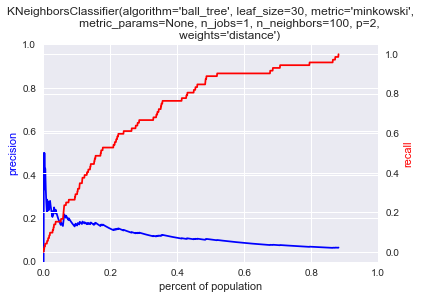

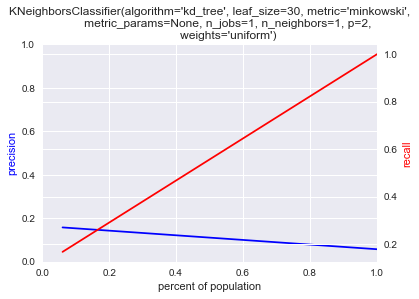

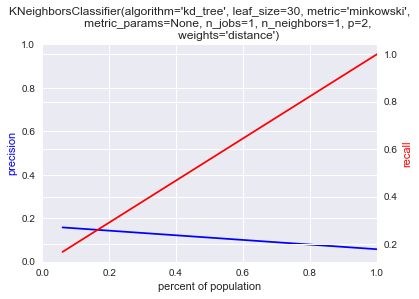

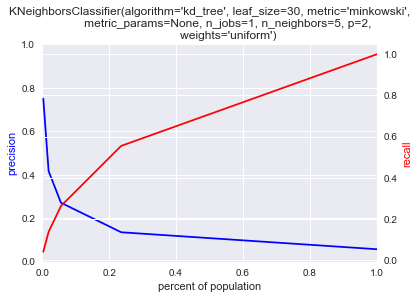

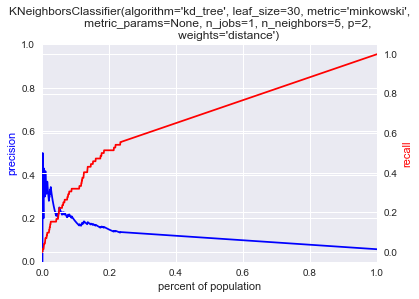

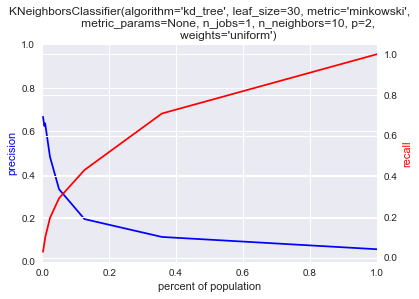

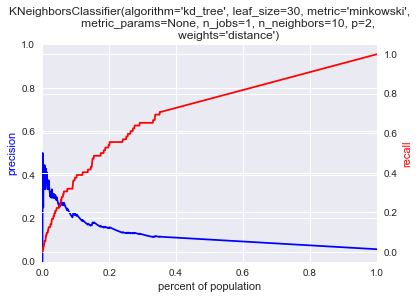

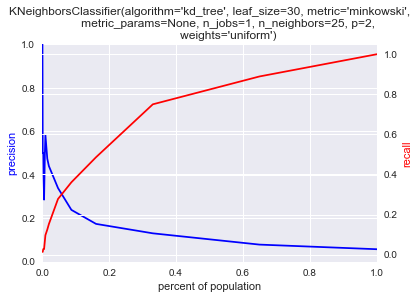

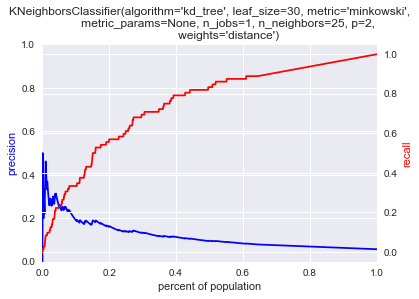

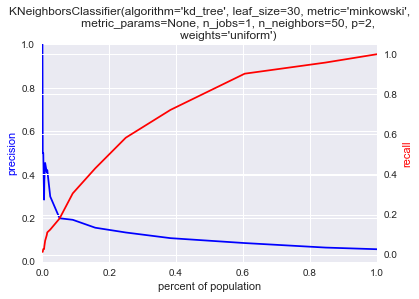

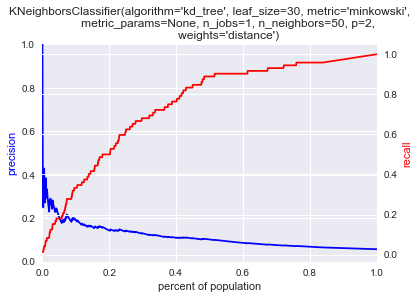

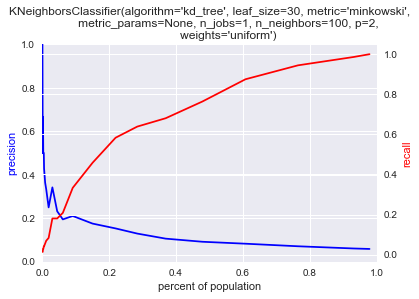

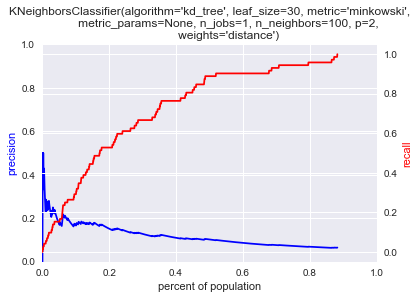

SVM


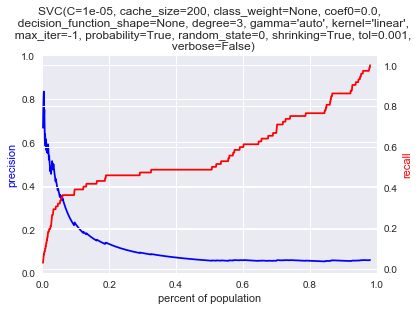

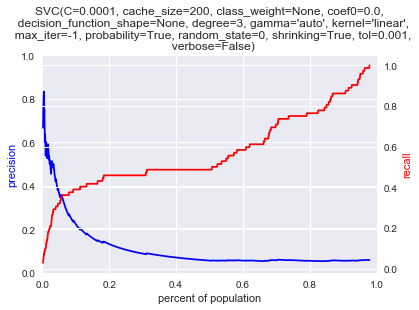

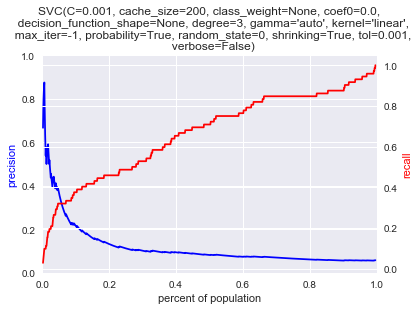

In [ ]:
SOME PRELIMINARY ROC curves. I eventually aborted this run of the small loop in favor of using a terminal overnight.

# Feature Selection

Using a random forest, we can identify the importance of features 


In [9]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

#df = u.get_subsample(data, 5000)
df = data
potential_features = list(data.columns[2:14])
y = df.serious_dlqin2yrs
X =df[potential_features].join(df.monthly_income.map(lambda x: math.log(x) if x!=0 else 0), rsuffix="_log")


def rf_feature_selection(X,y):
    '''
    identify important features using a random forest
    
    
    
    This is based on sklearn example code:
    http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py
    '''
    forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=0)

    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.show()

Feature ranking:
1. feature 5 (0.129706)
2. feature 12 (0.124128)
3. feature 0 (0.105268)
4. feature 4 (0.097960)
5. feature 7 (0.090882)
6. feature 1 (0.089481)
7. feature 6 (0.079380)
8. feature 3 (0.065565)
9. feature 2 (0.061315)
10. feature 9 (0.054666)
11. feature 10 (0.043717)
12. feature 8 (0.036002)
13. feature 11 (0.021929)


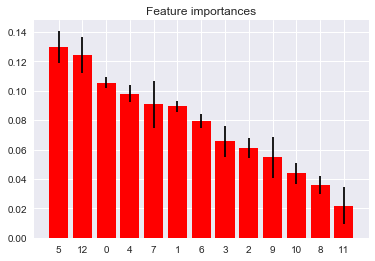

In [10]:
rf_feature_selection(X,y)

Collect top 5 features:
Note feature 12 is log(income) which did about the same as the income measure. It is somewhat surprising that factors that were more correlated with delinquency, such as number of dependents did not show up.  and the other "number of days past due" were not as important. The debt ratio groups, which discretized debt ratios, appears as the least useful. 

In [2]:
features = []
for x in [5,0,4,1,7]:
    features.append(potential_features[x])  
features

['monthly_income',
 'revolving_utilization_of_unsecured_lines',
 'debt_ratio',
 'age',
 'number_of_times90_days_late']

In [ ]:
df = data
X = df[features]
y = df.serious_dlqin2yrs

#models_to_run=['RF','DT','KNN', 'SVM', 'AB', 'GB', 'LR', 'NB']
grid_size = "smaller"
models_to_run=['RF','DT','GB','LR', 'NB', 'GB']

def run_magicloop(grid_size, models_to_run, outfile='results.csv', JUPTYER=1):
    clfs, grid = magic.define_clfs_params(grid_size)
    results_df = magic.clf_loop(models_to_run, clfs,grid, X,y)
    results_df.to_csv(outfile, index=False)
    return results_df

results_df = run_magicloop(grid_size, models_to_run)

In [4]:
results_df

model_type                                                clf  \
0         RF  (DecisionTreeClassifier(class_weight=None, cri...   
1         DT  DecisionTreeClassifier(class_weight=None, crit...   
2         NB                            GaussianNB(priors=None)   
3         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   

                                          parameters   auc-roc    p_at_5  \
0  {'max_depth': 1, 'max_features': 'sqrt', 'min_...  0.653223  0.464000   
1  {'criterion': 'gini', 'max_depth': 1, 'max_fea...  0.699723  0.759467   
2                                                 {}  0.659564  0.217600   
3  {'learning_rate': 0.1, 'max_depth': 1, 'n_esti...  0.653223  0.464000   

    p_at_10   p_at_20                        cnf   runtime  
0  0.672533  0.339600    [[34953, 0], [2547, 0]]  0.125045  
1  0.379733  0.256000    [[34953, 0], [2547, 0]]  0.056247  
2  0.164800  0.130267  [[34921, 32], [2485, 62]]  0.040034  
3  0.672533  0.339600    [[34953, 0], [2547, 0]]  0.136803

In [21]:
results_df

model_type                                                clf  \
0         RF  (DecisionTreeClassifier(class_weight=None, cri...   
1         DT  DecisionTreeClassifier(class_weight=None, crit...   
2        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
3         LR  LogisticRegression(C=0.01, class_weight=None, ...   
4         NB                            GaussianNB(priors=None)   
5         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   

                                          parameters   auc-roc    p_at_5  \
0  {'max_depth': 1, 'max_features': 'sqrt', 'min_...  0.705853  0.789333   
1  {'criterion': 'gini', 'max_depth': 1, 'max_fea...  0.603952  1.000000   
2  {'algorithm': 'auto', 'n_neighbors': 5, 'weigh...  0.663950  0.488533   
3                       {'C': 0.01, 'penalty': 'l1'}  0.662507  0.138667   
4                                                 {}  0.659564  0.217600   
5  {'learning_rate': 0.1, 'max_depth': 1, 'n_esti...  0.653223  0.464000   

    p_at_10   p_at_20   runtime  
0  0.394667  0.210667 -0.125176  
1  0.529067  0.264533 -0.049901  
2  0.321867  0.160933 -3.032433  
3  0.132267  0.120933 -0.471463  
4  0.164800  0.130267 -0.056506  
5  0.672533  0.339600 -0.121616

In [ ]:

# Compute confusion matrix
def plot_cnf(y_test,y_hat, class_names=y_test.unique()):
    cnf_matrix = confusion_matrix(y_test, y_hat)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    pl.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    pl.figure()
    ev.plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')


    pl.show()